In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [5]:
########## Section 1 = Selecting the images for the blending #######################
# Load the two images
image1= cv2.imread('oled2.jpg')
image2 = cv2.imread('sunset.jpg')

image1 = cv2.resize(image1, (1024, 1024))
image2 = cv2.resize(image2, (1024, 1024))
# Ensure both images have the same dimensions
height, width, _ = image1.shape
image2 = cv2.resize(image2, (width, height))


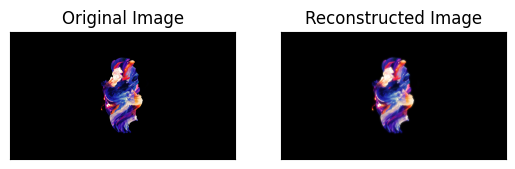

In [6]:
########### Section 2 = generate the Gaussian and Laplacian pyramids of an image #######################
# Load the input image
image = cv2.imread('oled1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Function to generate Gaussian pyramid
def generate_gaussian_pyramid(image, levels):
    pyramid = [image]
    for i in range(1, levels):
        image = cv2.pyrDown(image)
        pyramid.append(image)
    return pyramid

# Function to generate Laplacian pyramid
def generate_laplacian_pyramid(image, levels):
    gaussian_pyramid = generate_gaussian_pyramid(image, levels)
    laplacian_pyramid = [gaussian_pyramid[levels - 1]]
    for i in range(levels - 1, 0, -1):
        expanded = cv2.pyrUp(gaussian_pyramid[i])
        laplacian = cv2.subtract(gaussian_pyramid[i - 1], expanded)
        laplacian_pyramid.append(laplacian)
    return laplacian_pyramid

# Function to collapse the Laplacian pyramid into the original image
def collapse_laplacian_pyramid(laplacian_pyramid):
    image = laplacian_pyramid[0]
    for i in range(1, len(laplacian_pyramid)):
        expanded = cv2.pyrUp(image)
        image = cv2.add(expanded, laplacian_pyramid[i])
    return image

#demonstrating that the code is working

# Number of levels in the pyramid
num_levels = 5

# Generate Gaussian and Laplacian pyramids
gaussian_pyramid = generate_gaussian_pyramid(image, num_levels)
laplacian_pyramid = generate_laplacian_pyramid(image, num_levels)

# Collapse Laplacian pyramid to obtain the reconstructed image
reconstructed_image = collapse_laplacian_pyramid(laplacian_pyramid)

# Display the original and reconstructed images
plt.subplot(121), plt.imshow(image)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(reconstructed_image)
plt.title('Reconstructed Image'), plt.xticks([]), plt.yticks([])
plt.show()
##############################################

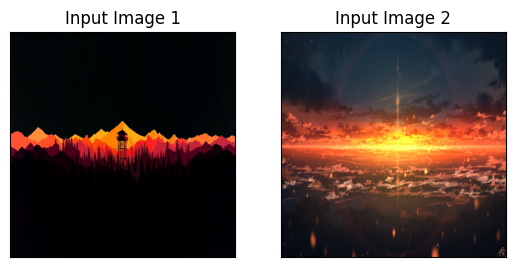

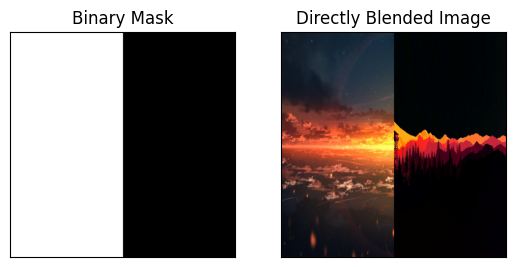

In [8]:
########### Section 3 = Make mask(s) that will act as the transition between your images (binary masks). #######################


# Create a grayscale mask with white on the left half and a transition in the middle
mask = np.zeros((height, width), dtype=np.uint8)

# Define the transition region (gray for gradual transition)
transition_width = 100  # Adjust the width of the transition region
mask[:, :width // 2] = 255  # White on the right half
    
##############################################

########### Section 4 = Direct Blending #######################

# Perform the blending
#It essentially sets blended_image to be the same as image1 at this stage.
blended_image = cv2.addWeighted(image1, 1, image2, 0, 0)  # Initialize blended image with image1

#Here, it takes blended_image and uses a bitwise operation (cv2.bitwise_and) with 255 - mask. 
#This operation effectively replaces the pixels in blended_image with zero (black) in 
#the areas where the mask is white (i.e., where you want image1 to show). 
#This step creates a blank canvas where image2 will be blended in.
blended_image = cv2.bitwise_and(blended_image, blended_image, mask=255 - mask)  # Blend using the mask

#Finally, this line takes the blank canvas created in the previous step and adds image2 to it, 
#but only in the areas where the mask is not zero (i.e., the areas where you want image2 to show). 
#This addition effectively blends image2 with the blank canvas, creating the final blended image.
blended_image = cv2.add(blended_image, cv2.bitwise_and(image2, image2, mask=mask))  # Blend using the mask

# Display the blended image

plt.subplot(121), plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.title('Input Image 1'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
plt.title('Input Image 2'), plt.xticks([]), plt.yticks([])
plt.show()

plt.subplot(121), plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
plt.title('Binary Mask'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(cv2.cvtColor(blended_image.astype(np.uint8), cv2.COLOR_BGR2RGB))
plt.title('Directly Blended Image'), plt.xticks([]), plt.yticks([])
plt.show()

##############################################

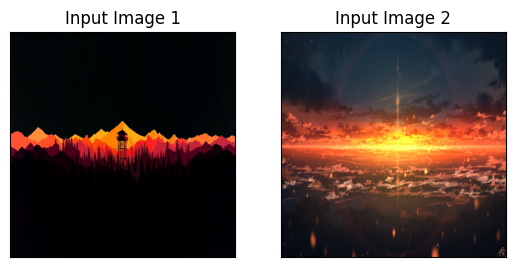

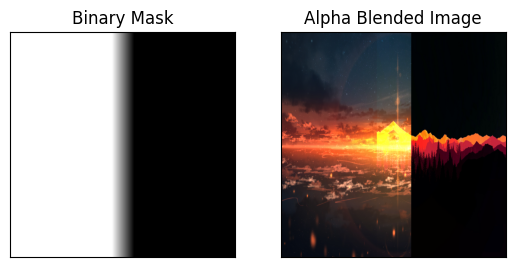

In [9]:
########### Section 5 = Alpha Blending #######################

# Create a new grayscale mask 
mask2 = mask

for x in range(width // 2 - transition_width // 2, width // 2 + transition_width // 2):
    mask2[:, x] = int(255 * (1 - (x - (width // 2 - transition_width // 2)) / transition_width))

# Apply Gaussian blur to the mask for feathering
blurred_mask = cv2.GaussianBlur(mask2, (101, 101), 0)  #adjust the kernel sizefor the blur effect

# Display the alpha-blended image

alpha_blended_image = cv2.addWeighted(image1, 1, image2, 0, 0)  # Initialize blended image with image1

alpha_blended_image = cv2.bitwise_and(alpha_blended_image, alpha_blended_image, mask=255 - blurred_mask)  # Blend using the mask

alpha_blended_image = cv2.add(alpha_blended_image, cv2.bitwise_and(image2, image2, mask=blurred_mask))  # Blend using the mask

# Display the blended image

plt.subplot(121), plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.title('Input Image 1'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
plt.title('Input Image 2'), plt.xticks([]), plt.yticks([])
plt.show()

plt.subplot(121), plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
plt.title('Binary Mask'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(cv2.cvtColor(alpha_blended_image.astype(np.uint8), cv2.COLOR_BGR2RGB))
plt.title('Alpha Blended Image'), plt.xticks([]), plt.yticks([])
plt.show()

##############################################

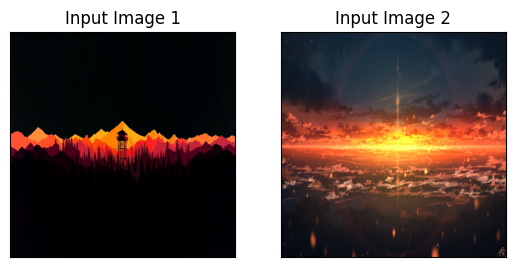

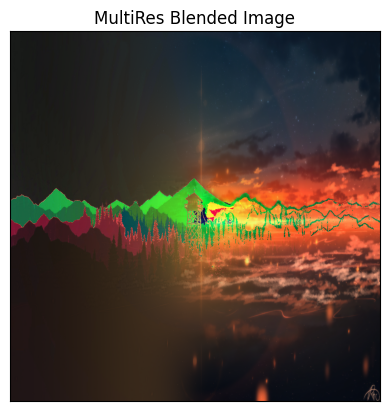

In [10]:
########### Section 6 = Multi Resolution Blending #######################

def multiblend(image1, image2, levels=6):
    # Load the input images
    img1 = image1
    img2 = image2
    
    levels = 10 #control the depth

    # Convert images to float32
    img1 = np.float32(img1)
    img2 = np.float32(img2)

    # Generate Gaussian pyramid for mask
    mask = np.zeros((img1.shape[0], img1.shape[1], 3), dtype=np.float32)
    mask[:, :img1.shape[1]//2, :] = 1
    mask_pyramid = generate_gaussian_pyramid(mask, levels)

    # Generate Laplacian pyramid for image1
    img1_pyramid = generate_laplacian_pyramid(img1, levels)

    # Generate Laplacian pyramid for image2
    img2_pyramid = generate_laplacian_pyramid(img2, levels)

    # Adjust the dimensions of the mask pyramid to match the image pyramids
    for i in range(levels):
        mask_pyramid[i] = cv2.resize(mask_pyramid[i], img1_pyramid[i].shape[:2][::-1])

    # Blend the images using multiresolution blending algorithm
    blended_pyramid = []
    for i in range(len(img1_pyramid)):
        blended_pyramid.append(mask_pyramid[i] * img1_pyramid[i] + (1 - mask_pyramid[i]) * img2_pyramid[i])

    # Collapse the blended pyramid to obtain the final blended image
    blended_image = collapse_laplacian_pyramid(blended_pyramid)

    return blended_image

# Perform multiresolution blending
blended_image = multiblend(image1, image2)

# Display the blended image

plt.subplot(121), plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.title('Input Image 1'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
plt.title('Input Image 2'), plt.xticks([]), plt.yticks([])
plt.show()


plt.imshow(cv2.cvtColor(blended_image.astype(np.uint8), cv2.COLOR_BGR2RGB))
plt.title('MultiRes Blended Image'), plt.xticks([]), plt.yticks([])
plt.show()

##############################################